In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import time
import gc
import shap
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, precision_score, recall_score, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier
import pickle
%matplotlib inline

In this notebook we will perform the model optimisation part for the project 7 of OpenClassRooms Data Scientist training <br>
We will take several steps:
* Data loading and preparation for optimisation
* Create custom scorer for our problematic and performed GridSearchCV on our LGBM classifier model with RUS data (see P07_02_dossier_notebook01.ipynb for explenations)
* Optimise the treshold value on predict probability of the model to ensure our decision for refused loan (regarding our custom scorer)
* Save our best model with pickle for API use
* Discover Feature importance with SHAP Library and export our explainer of the best model with pickle for Dashboard use


## **DataLoading and preparation**

### Loading file and extract X and y

In [9]:
# loading raw file
df_data = pd.read_csv('Home_credit_risk_data_modeling.csv', index_col=0)
df_data.info()
# getting only train data available with target
df_train_sample = df_data.loc[~(df_data['TARGET'].isnull())]
# define features and target
X = df_train_sample.drop(columns = ['TARGET','SK_ID_CURR','index']).copy()
y = df_train_sample['TARGET'].copy()
index_global_SK_ID_CURR = df_train_sample['SK_ID_CURR'].copy()
# Associate ID with index of our X data
X = X.set_index(index_global_SK_ID_CURR)
# getting rid of our initial df
del df_data, df_train_sample
gc.collect()
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(176)
memory usage: 2.1 GB
X shape: (307507, 795)
y shape: (307507,)


### Preprocessing X data: Replace infinit values and impute missing ones

In [11]:
# Replace inf values by max() and min() values
col_min_max = {np.inf: X[np.isfinite(X)].max(),    # column-wise max
              -np.inf: X[np.isfinite(X)].min()}    # column-wise min

X = X.replace({col: col_min_max for col in X.columns})
# Checking that there is no infinite values anymore
np.isinf(X).values.sum()

0

In [12]:
# features detection before imputation, numerical continue or numerical discrete
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''
    
    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list

In [13]:
# Imputation
numerical_cont_list, numerical_disc_list = list_features_att(X)
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list])
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')
#Checking all values have been imputed
X.isnull().sum().sum()

time for imputation: 36.71


### Splitting into X_train and X_test Normalise normalize and use undersampling

In [15]:
time_init = time.time()
# Data split (with stratified mode)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=4)
# Getting index for later
index_train = X_train.index
index_test = X_test.index
# Normalization of the imput data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
undersampling = RandomUnderSampler(random_state = 4)
X_train_rus, y_train_rus = undersampling.fit_resample(X_train, y_train)
print (f'Time for Spliting, Normalize and Undersample: {time.time() - time_init:.2f}')

Time for Spliting, Normalize and Undersample: 14.99


## **Model optimization with custom metric**

### Initial model values with AUC score for optimization (see P07_02_dossier_notebook01.ipynb for explenations) <br>
Our selected model is LGBM classifier with RUS data and parameters change:
* n_estimators = 60
* max_depth = 7
* learning rate = 0.1
--> let's verifiy our score with it

In [26]:
lgbm_model = LGBMClassifier(n_estimators=60, max_depth=7, learning_rate=0.1, random_state=4)
time1 = time.time()
lgbm_model.fit(X_train_rus, y_train_rus)
time2 = time.time()
y_pred = lgbm_model.predict(X_test)
y_pred_prob = lgbm_model.predict_proba(X_test)[:,1]
print('model: LGBM classifier') 
print(f'Score AUC: {roc_auc_score(y_test, y_pred_prob):.4f}')
print(f'F1_score: {f1_score(y_test, y_pred):.4f}')
print(f'F2_score: {fbeta_score(y_test, y_pred, beta=2):.4f}')
print(f'Precision_score: {precision_score(y_test,y_pred):.4f}')
print(f'Recall_score: {recall_score(y_test, y_pred):.4f}')
print(f'Train Time(s): {time2 - time1:.3f}')

model: LGBM classifier
Score AUC: 0.7725
F1_score: 0.2790
F2_score: 0.4378
Precision_score: 0.1738
Recall_score: 0.7057
Train Time(s): 4.536


--> This are the results expected

### Create custom score for our problematic
--> What is wanted here is to catch as accuratly as possible clients that would be accepted but that should be rejected : False Negative (it could be done with F2 score that give more importance to recall where FN are present but we will try a custom score). <br>
--> Furthemore it is also important (but not as important as FN) to catch client that would be rejected but that could refund : False Positive. <br>
--> Our function will count the number of FP and FN with a greater weight on FN (X10). The optimization for our score would be 'Smaller the better'.

In [31]:
# create custom metrics
def custom_metrics_home_risk(y_true, y_pred):
    ''' Scoring function to minimise False Positive and False Negative for the classifier
    We want to reduce False Positive as possible but also and with a greater weight (X10) the False Negative
    y_true --> real value
    y_pred --> value estimated by a classifier
    sklearn.metrics.confusion_matrix must be imported to use it'''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    met = fp + (10 * fn)
    return met
# create custom scorer with sklearn to implement in sklearn GridSearchCV (don't forget greater_is_better = False, we want to minimize the score
custom_scorer_home_risk = make_scorer(custom_metrics_home_risk, greater_is_better=False)

testing our metrics function on our data

In [32]:
custom_metrics_home_risk(y_test, y_pred)

31262

### GridSearchCV with our new metric

In [34]:
# prameters dict
models_params = {'LGBM Classifier':{'model':LGBMClassifier(random_state=4),
                                       'params':{'n_estimators':range(55,65,1), 'max_depth':range(5,10,1), 'learning_rate':[0.1, 0.5]}}}
# grid search
scores_CV5 = list()
for model_name,mp in models_params.items():
    gride_mod = GridSearchCV(mp['model'],mp['params'], cv = 5, scoring=custom_scorer_home_risk, n_jobs=-1)
    gride_mod.fit(X_train_rus,y_train_rus)
    scores_CV5.append({'model':model_name, 'best_score custom':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':'train RUS data'})
# create df for gridsearch summary results   
df_scores_CV5 = pd.DataFrame(scores_CV5)
df_scores_CV5

,model,best_score custom,best parameters,Best model,Refit Time(s),Comment
0,LGBM Classifier,-12783.4,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...","LGBMClassifier(max_depth=7, n_estimators=62, r...",8.381584,train RUS data


--> negative value in 'best custom score' is due to the implementation in sklearn

In [36]:
print(f'Best paramater for our custom score: {gride_mod.best_params_}')

Best paramater for our custom score: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 62}


In [38]:
# evaluate the score on test data
lgbm_best_model = df_scores_CV5.loc[0, 'Best model']
time1 = time.time()
lgbm_best_model.fit(X_train_rus, y_train_rus)
time2 = time.time()
y_pred = lgbm_best_model.predict(X_test)
y_pred_prob = lgbm_best_model.predict_proba(X_test)[:,1]
print('model: LGBM classifier')
print(f'Custom Score: {custom_metrics_home_risk(y_test, y_pred)}')
print(f'Score AUC: {roc_auc_score(y_test, y_pred_prob):.4f}')
print(f'F1_score: {f1_score(y_test, y_pred):.4f}')
print(f'F2_score: {fbeta_score(y_test, y_pred, beta=2):.4f}')
print(f'Precision_score: {precision_score(y_test,y_pred):.4f}')
print(f'Recall_score: {recall_score(y_test, y_pred):.4f}')
print(f'Train Time(s): {time2 - time1:.3f}')

model: LGBM classifier
Custom Score: 31320
Score AUC: 0.7728
F1_score: 0.2786
F2_score: 0.4372
Precision_score: 0.1736
Recall_score: 0.7045
Train Time(s): 4.711


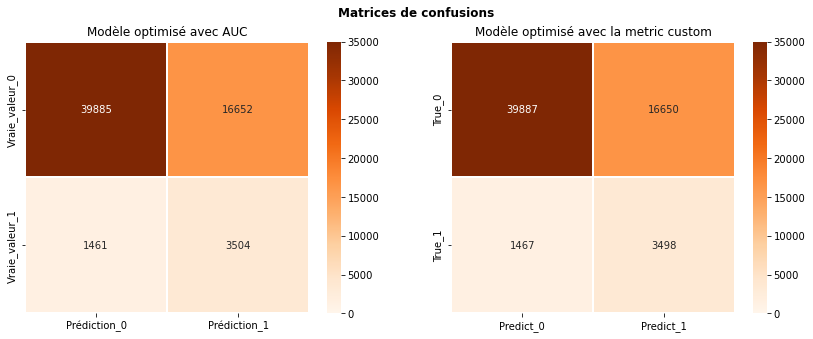

In [52]:
# Confusion matrix comparison before/after optimization
figure_cm = plt.figure(figsize=(14,5))
plt.title('Matrices de confusions', fontweight = 'bold', pad=25)
plt.axis('off')
# Confusion matrix with initial model and treshold at 0.5
figure_cm.add_subplot(1,2,1)
plt.title('Modèle optimisé avec AUC')
cm0 = confusion_matrix(y_test, lgbm_model.predict(X_test))
df_cm0 = pd.DataFrame(cm0, index = ['Vraie_valeur_0', 'Vraie_valeur_1'], columns=['Prédiction_0', 'Prédiction_1'])
sns.heatmap(df_cm0, fmt='g',cmap='Oranges', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
# Confusion matrix with optimised model with custom metric
figure_cm.add_subplot(1,2,2)
plt.title('Modèle optimisé avec la metric custom')
cm = confusion_matrix(y_test, lgbm_best_model.predict(X_test))
df_cm = pd.DataFrame(cm, index = ['True_0', 'True_1'], columns=['Predict_0', 'Predict_1'])
sns.heatmap(df_cm, fmt='g', cmap='Oranges', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
#plt.savefig('Confusion_matrix_avant_après_GridSearchCV_custom_score.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> our optimisation on train rus data have not optimized our result on test data... <br>
--> let's keep that for now, result are very close

### Optimizing the decision treshold (0.5 in the model) with our metric custom and best model

In [50]:
# Function to apply a new treshold
def Treshold_applied(y_prob_pos, treshold):
    '''Function to applied a new treshold for positive value for our binary classifier
    y_prob_pos --> postive probability (rejected loan) return by our classifier on our data must be 1-D
    treshold --> treshold to applied on our classifier probability and return estimated label with it'''
    return (y_prob_pos >= treshold).astype('int')

# Evaluate best treshold with our custom metrics
tresh = np.arange(0,1, 0.001)
scores = [custom_metrics_home_risk(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], t)) for t in tresh]
# lower the value better the result, we use argmin (change this step if our metric must be greater the better)
best_ix = np.argmin(scores)
print(f'Treshold:{tresh[best_ix]} \nBest custom score: {scores[best_ix]} \
      \nScore AUC:{roc_auc_score(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], tresh[best_ix]))}')

Treshold:0.49 
Best custom score: 31240       
Score AUC:0.7067060398611423


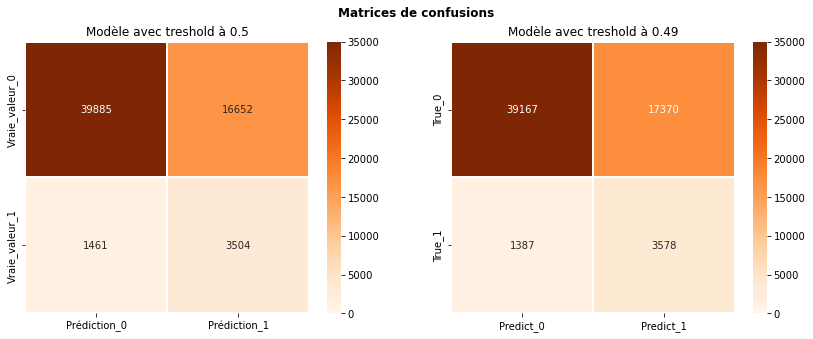

In [53]:
# Confusion matrix comparison before/after treshold optimization
treshold = 0.49
figure_cm = plt.figure(figsize=(14,5))
plt.title('Matrices de confusions', fontweight = 'bold', pad=25)
plt.axis('off')
# Confusion matrix with initial model and treshold at 0.5
figure_cm.add_subplot(1,2,1)
plt.title('Modèle avec treshold à 0.5')
cm0 = confusion_matrix(y_test, lgbm_model.predict(X_test))
df_cm0 = pd.DataFrame(cm0, index = ['Vraie_valeur_0', 'Vraie_valeur_1'], columns=['Prédiction_0', 'Prédiction_1'])
sns.heatmap(df_cm0, fmt='g',cmap='Oranges', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
# Confusion matrix treshold changed
figure_cm.add_subplot(1,2,2)
plt.title('Modèle avec treshold à 0.49')
cm = confusion_matrix(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], treshold))
df_cm = pd.DataFrame(cm, index = ['True_0', 'True_1'], columns=['Predict_0', 'Predict_1'])
sns.heatmap(df_cm, fmt='g', cmap='Oranges', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
#plt.savefig('Confusion_matrix_avant_après_treshold_opti.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> Treshold set to 0.49 catch some FP but in the other hand we lose some true positive in false positive...

## **Save our best model with pickle and export a sample of test data for API use**

In [55]:
# export a sample of our test data for API purpose (also dashboard)
# we can't have to big file because on Heroku we have a limitation on file size
# add predict proba to our data

test_sample_data = pd.DataFrame(X_test, columns=X.columns, index= index_test)
test_sample_data

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
345593         0.720156     -0.717411        -0.665847     -0.577413   
402371         0.720156     -0.717411        -0.665847     -0.577413   
262097         0.720156     -0.717411        -0.665847     -0.577413   
100435         0.720156     -0.717411        -0.665847     -0.577413   
239891         0.720156     -0.717411        -0.665847     -0.577413   
...                 ...           ...              ...           ...   
304484        -1.388588      1.393901        -0.665847     -0.577413   
348857        -1.388588     -0.717411        -0.665847     -0.577413   
114730        -1.388588     -0.717411        -0.665847      0.808244   
427417        -1.388588      1.393901        -0.665847     -0.577413   
443947        -1.388588     -0.717411        -0.665847     -0.577413   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
345593              0.497709    1.304607     0.407461         1.586177   
402371             -0.358448   -1.042371    -0.881978        -0.971572   
262097              0.567599    2.792815     1.617047         2.195165   
100435             -0.218667   -0.371806    -0.747752        -0.240786   
239891             -0.271085   -1.098251    -0.804612        -1.032470   
...                      ...         ...          ...              ...   
304484              0.043421    2.374259     2.569057         2.304783   
348857             -0.043941   -0.818849    -0.430208        -0.727977   
114730              0.043421    0.745803     2.782513         0.977189   
427417              0.654962   -0.785522    -0.749616        -0.825415   
443947             -0.218667   -0.930610    -0.733459        -0.849774   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
345593                       -0.662420   -1.775690       0.000441   
402371                       -0.775054   -0.987882       0.000441   
262097                       -1.053164   -0.231695       0.472116   
100435                        1.081304   -0.096269      -1.088109   
239891                        0.847422   -1.718862       0.000441   
...                                ...         ...            ...   
304484                        0.847422   -0.590769      -0.439471   
348857                        0.565259    1.172978       0.314913   
114730                        0.565259   -0.023859       0.945613   
427417                        0.565259    0.354235       0.103421   
443947                       -0.191472    1.356754       0.375340   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
345593              -0.553659        -0.692531     0.000691    0.002016   
402371              -1.378875        -0.571192     0.000691    0.002016   
262097              -0.488152         1.674573     0.000691    0.002016   
100435               0.482541         1.975600     0.000691    0.002016   
239891               1.412114        -1.258779     0.000691    0.002016   
...                       ...              ...          ...         ...   
304484              -0.748478         0.894821    -0.727848    0.002016   
348857               0.075321        -0.313264     0.000691    0.002016   
114730               0.711389        -0.126945     0.000691    0.002016   
427417              -0.418958        -0.974329    -1.303641    0.002016   
443947               0.286304         0.538098     0.000691    0.002016   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
345593           -2.131437        -0.498113          0.043658   -0.625330   
402371 

In [57]:
test_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61502 entries, 345593 to 443947
Columns: 795 entries, CODE_GENDER to CC_COUNT
dtypes: float64(795)
memory usage: 373.5 MB


## **Using SHAP for getting global and local feature importance**

### Global importance

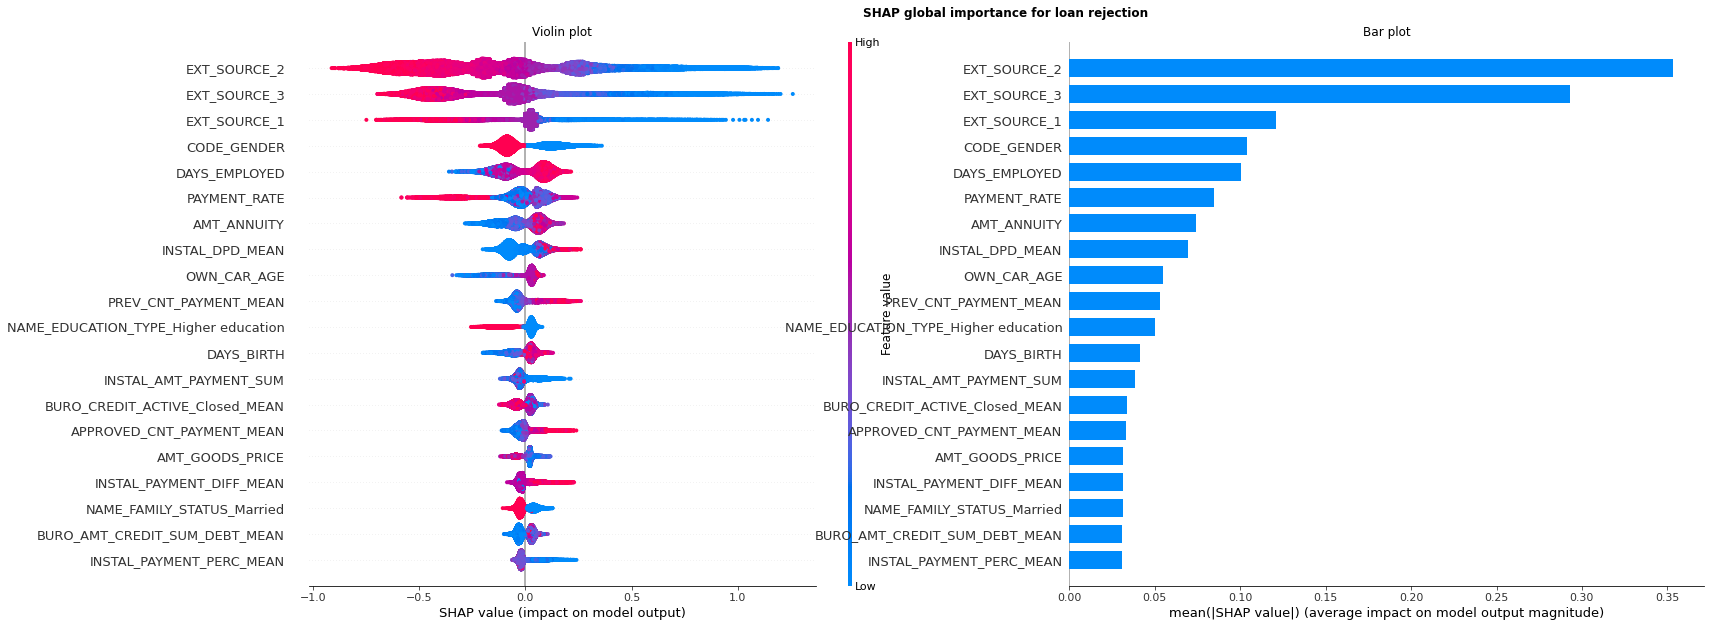

In [75]:
# using tree explainer with LGBM classifier
explainer =  shap.Explainer(lgbm_best_model)
shap_values =explainer.shap_values(X_test)
# ploting SHAP features importances, we focuse on the probability to have the loan rejected
figure_shap_1 = plt.figure(figsize=(25,10))
plt.title('SHAP global importance for loan rejection', fontweight='bold', pad=25)
plt.axis('off')
figure_shap_1.add_subplot(1,2,1)
plt.title('Violin plot')
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, show=False, plot_size=None)
figure_shap_1.add_subplot(1,2,2)
plt.title('Bar plot')
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, plot_type='bar', show=False, plot_size=None)
plt.show()

### **locale importance (Force_plot and waterfall)**

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


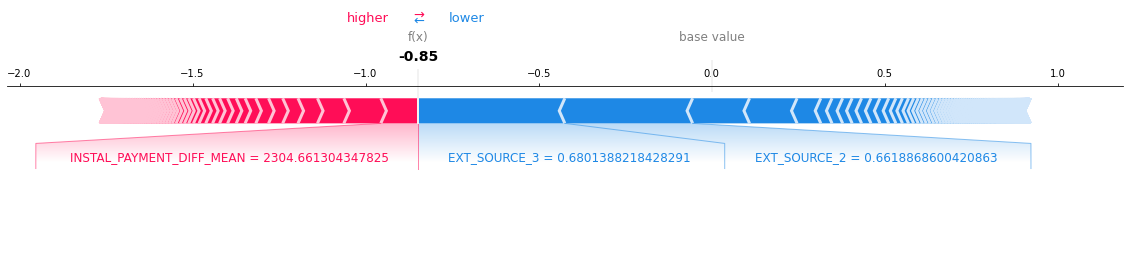

In [95]:
# Force plot
choosen_client = X_test[3,:]
shap_values = explainer.shap_values(choosen_client.reshape(1, -1))
# using invert transform of the std_scaler to get real values of data into our force plot
choosen_client = std_scaler.inverse_transform(choosen_client)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_client, feature_names=X.columns, matplotlib=True)

In [99]:
# Waterfallplot
# let's try defining a class shap object to create waterfall plot
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


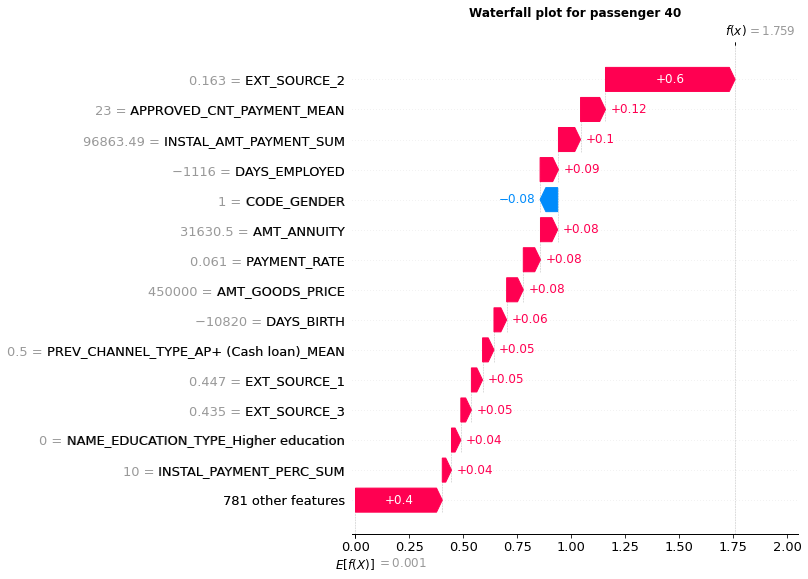

In [118]:
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test)[1][5,:],
                         feature_names = X.columns,
                         data = std_scaler.inverse_transform(test_sample_data.iloc[5,:]))

figure_waterfall = plt.figure(figsize=(7,7), facecolor='w')
plt.title('Waterfall plot for passenger 40', fontweight='bold')
shap.waterfall_plot(shap_object, max_display=15)

In [117]:
gc.collect()

15